# PSF estimation

This notebook calculates the empirical PSF (Point Spread Function) from images in different bands. It's used as a preliminary step to SourceXtractor++, which requires PSF for source modeling. 

To calculate the PSFs, it first detects, using SExtractor, point-like sources in an image (by default the F200W band for JWST, as it gave the best results during testing), and then uses this catalog of sources to extract vignets of the point-like sources in all the bands. Then, it uses PSFEx to create the PSF for each band.

To work, this notebook requires you to have [PSFEx](https://psfex.readthedocs.io/en/latest/) and [SExtractor](https://sextractor.readthedocs.io/en/latest/Introduction.html) installed on your machine.

In [1]:
import glob
import re
import dja_sepp

## Point-like sources detection

This step consists in two sub-steps:
1. Running SExtractor on the image in the chosen band for point-like sources detectino (by default, F200W for JWST)
2. Detecting point-like sources in a MU_MAX v. MAG_AUTO plot. MU_MAX is the maximum pixel value for each source, given in mag.arcsec^{-2}, and MAG_AUTO is a measure of the total source magnitude, in mag. Point-like sources tend to fall on a straight line, making it easy to select them.

*N.B.: The selection of the point-like sources makes use of a linear regression to find the line, and a threshold `y_max` to exclude extended sources and allow for a good linear regression. This parameter may need to be tweaked for your images. You can use the "Star line detection after galaxy cluster removal" image to see the threshold.*

In [2]:
# F200W Point-like sources detection
home = "/home/aurelien/DAWN/DJA-SEpp"
config_folder = "/home/ec2-user/DJA-SEpp/config"
field = 'ceers-full-grizli-v7.2'
filter = 'f200w'

> 
----- SExtractor 2.28.0 started on 2024-05-21 at 11:55:31 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for gds-grizli-v7.2-f200w-clear_drc_sci.fits
----- Measuring from: gds-grizli-v7.2-f200w-clear_drc_sci.fits
      "Unnamed" / no ext. header / 28672x28672 / 32 bits (floats)
> Looking for gds-grizli-v7.2-f200w-clear_drc_wht.fits
----- Weighting from: gds-grizli-v7.2-f200w-clear_drc_wht.fits
      "Unnamed" / no ext. header / 28672x28672 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at l

DBSCAN clustering : (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]), array([  830, 19377,     5,     9,     9,     8,     7,     8,    10,
           7,     7,     8,     5,     5,     9,     5,     9,     5,
           7,     7,     5,     6,     7,     6,     5,    11,    12,
          11,    11,     9,     5,     8,     5,     3,     7,     5,
           5,     6,     4,     6,     4,     7,     5,     5,     5,
           6]))


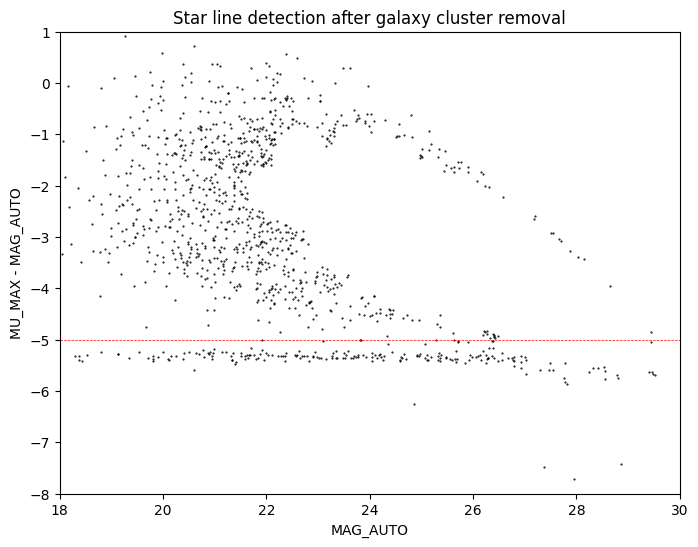

RANSAC Slope : -0.002
Star line    : -5.354


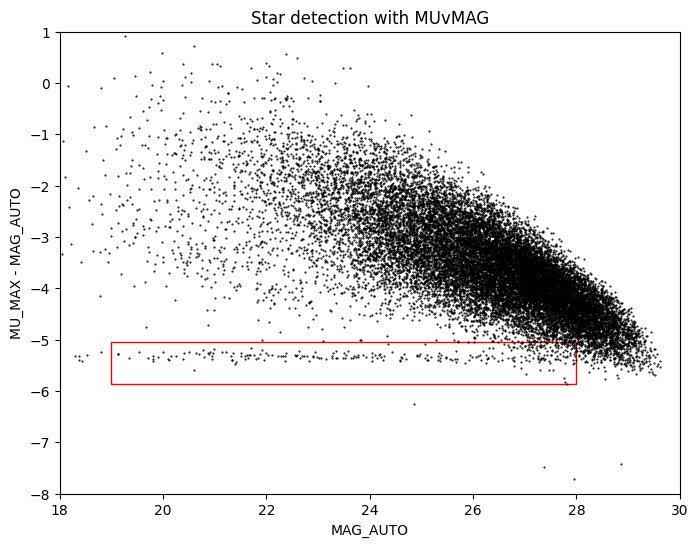

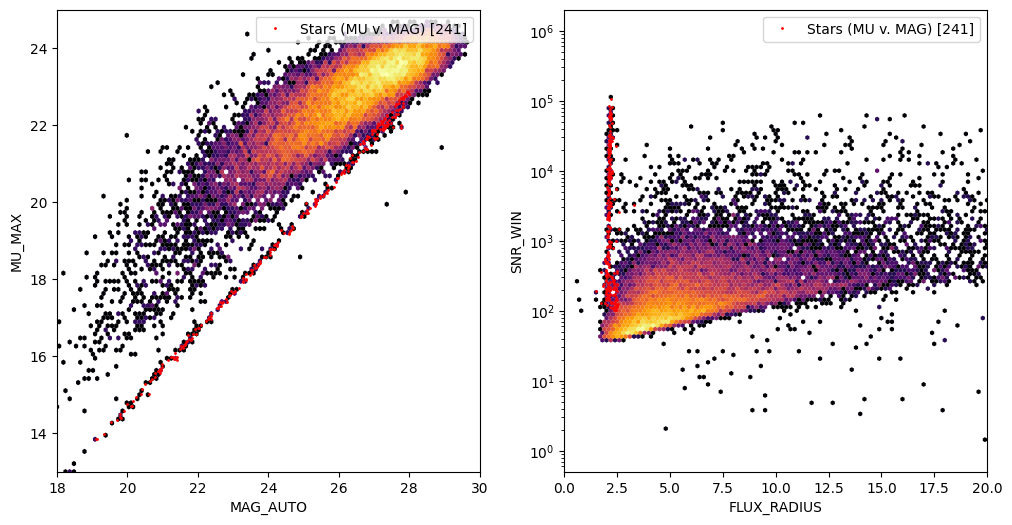

In [6]:
dja_sepp.sextractor.extract_stars(detect_img      = glob.glob(f"{home}/fields/{field}/image/*{filter}*sci*.fits")[0], \
                                  weight_img      = glob.glob(f"{home}/fields/{field}/image/*{filter}*wht*.fits")[0], \
                                  output_cat      = f"{home}/fields/{field}/catalog/{field}_drc_cat.fits", \
                                  output_cat_star = f"{home}/fields/{field}/catalog/{field}_drc_cat_star.fits", \
                                  config_folder   = config_folder, \
                                  dir_chckimg     = f"{home}/fields/{field}/catalog/checkimages", \
                                  detect_thresh = 8.0, \
                                  y_max = -5.0, \
                                  save_chckimg = False, plot = True, clean = True, verbose = True)

In [7]:
# Save star catalog to S3
dja_sepp.s3.save_s3(f"{home}/fields/{field}/catalog/{field}_drc_cat_star.fits", 'aurelien-sepp', f"{field}/catalog")

## Calculate PSF for each band

The next step is, for each band, to : 
1. run SExtractor on the different bands,
2. cross-match this catalog with the previous point-like sources catalog,
3. run PSFEx on this cross-matched catalog to create the PSF for this band.

In [14]:
# Filter list (for file organization and easy access)

# filter_list = ['f090w', 'f115w', 'f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f335m', 'f356w', 'f410m', 'f444w']
filter_list = [re.search('(f\d+\w+)', filename).group(1) for filename in glob.glob(f"{home}/fields/{field}/image/*clear*sci*")]
filter_list.sort()
filter_list

['f444w']

F444W
Running SExtractor


> 
----- SExtractor 2.28.0 started on 2024-05-21 at 12:49:25 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for gds-grizli-v7.2-f444w-clear_drc_sci.fits
----- Measuring from: gds-grizli-v7.2-f444w-clear_drc_sci.fits
      "Unnamed" / no ext. header / 14336x14336 / 32 bits (floats)
> Looking for gds-grizli-v7.2-f444w-clear_drc_wht.fits
----- Weighting from: gds-grizli-v7.2-f444w-clear_drc_wht.fits
      "Unnamed" / no ext. header / 14336x14336 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at l

Opening star catalogs
Matching stars
Running PSFEX



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.2 started on 2024-05-21 at 12:50:29 with 16 threads

> 
----- 1 input catalogues:
GDS-f444w-clear_drc_:  "no ident        "    1 extension     230 detections

> Initializing contexts...
> Reading data from GDS-f444w-clear_drc_cat_star...
> Computing final PSF model for GDS-f444w-clear_drc_cat_star...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for GDS-f444w-clear_drc_cat_star...
GDS-f444w-clear_d           78/85      1.00   1.07   3.76  0.00  0.04  0.01
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving PSF model and metadata for GDS-f444w-clear_drc_cat_star...
> Writing XML file...
> 
> All done (in 3.0 s)


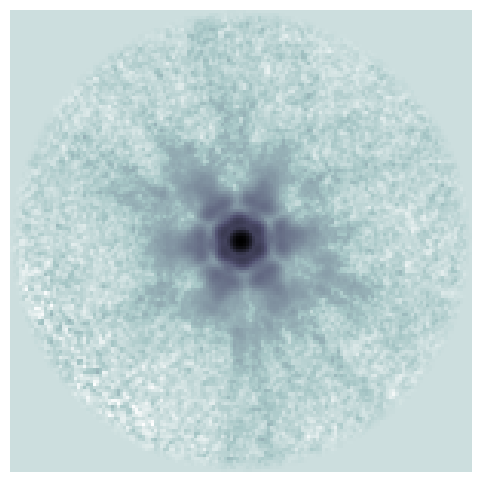

In [15]:
# Run SExtractor, cross-match and PSFEx for each band
for filter in filter_list:
    print(filter.upper())
    print("Running SExtractor")
    dja_sepp.sextractor.extract_stars_catalog(detect_img      = glob.glob(f"{home}/fields/{field}/image/*{filter}*sci.fits")[0], \
                                              weight_img      = glob.glob(f"{home}/fields/{field}/image/*{filter}*wht.fits")[0], \
                                              output_cat      = f"{home}/fields/{field}/catalog/{field}-{filter}-clear_drc_cat.fits", \
                                              output_cat_star = f"{home}/fields/{field}/catalog/{field}-{filter}-clear_drc_cat_star.fits", \
                                              input_cat_star  = f"{home}/fields/{field}/catalog/{field}_drc_cat_star.fits", \
                                              config_folder   = config_folder, \
                                              dir_chckimg     = f"{home}/fields/{field}/catalog/checkimages", \
                                              detect_thresh = 2.5, \
                                              save_chckimg = False, plot = False, clean = True, run_sex = True, verbose = True)
    print("Running PSFEX")
    dja_sepp.psfex.run_psfex(cat_name    = f"{home}/fields/{field}/catalog/{field}-{filter}-clear_drc_cat_star.fits",
                             output_cat  = f"{home}/fields/{field}/catalog/{field}-{filter}-clear_drc_cat_star_psf.fits",
                             dir_chckimg = f"{home}/fields/{field}/catalog/checkimages",
                             dir_psfex   = f"{home}/fields/{field}/psfex",
                             config_file = f"{config_folder}/psfex_default.conf",
                             fwhm_range  = '1.0, 10.0',
                             save_psf_png = True,
                             verbose = True)

In [17]:
# Save PSFs to S3
psf_list = glob.glob(f"{home}/fields/{field}/psfex/*star_psf.psf")
for psf in psf_list:
    dja_sepp.s3.save_s3(psf, 'aurelien-sepp', f"{field}/psfex")

## Visualize all PSFs

With the PSFs created for all the bands, it can be useful to visualize them to inspect for any defects or artefacts.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib import patheffects
from astropy.io import fits
from dja_sepp.utils import color_dict, channel_dict, channel_color_dict

In [4]:
psf_list = glob.glob(f"{home}/fields/{field}/psfex/*star_psf.psf")
filter_list = [re.search("f{1}\d+\w{1}",psf).group() for psf in psf_list]
psf_list, filter_list = zip(*sorted(zip(psf_list, filter_list)))
psf_list

('/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/psfex/ceers-full-grizli-v7.2-f115w-clear_drc_cat_star_psf.psf',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/psfex/ceers-full-grizli-v7.2-f150w-clear_drc_cat_star_psf.psf',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/psfex/ceers-full-grizli-v7.2-f182m-clear_drc_cat_star_psf.psf',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/psfex/ceers-full-grizli-v7.2-f200w-clear_drc_cat_star_psf.psf',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/psfex/ceers-full-grizli-v7.2-f210m-clear_drc_cat_star_psf.psf',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/psfex/ceers-full-grizli-v7.2-f277w-clear_drc_cat_star_psf.psf',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/psfex/ceers-full-grizli-v7.2-f356w-clear_drc_cat_star_psf.psf',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/psfex/ceers-full-grizli-v7.2-f410m-clear_drc_cat_star_psf.psf',


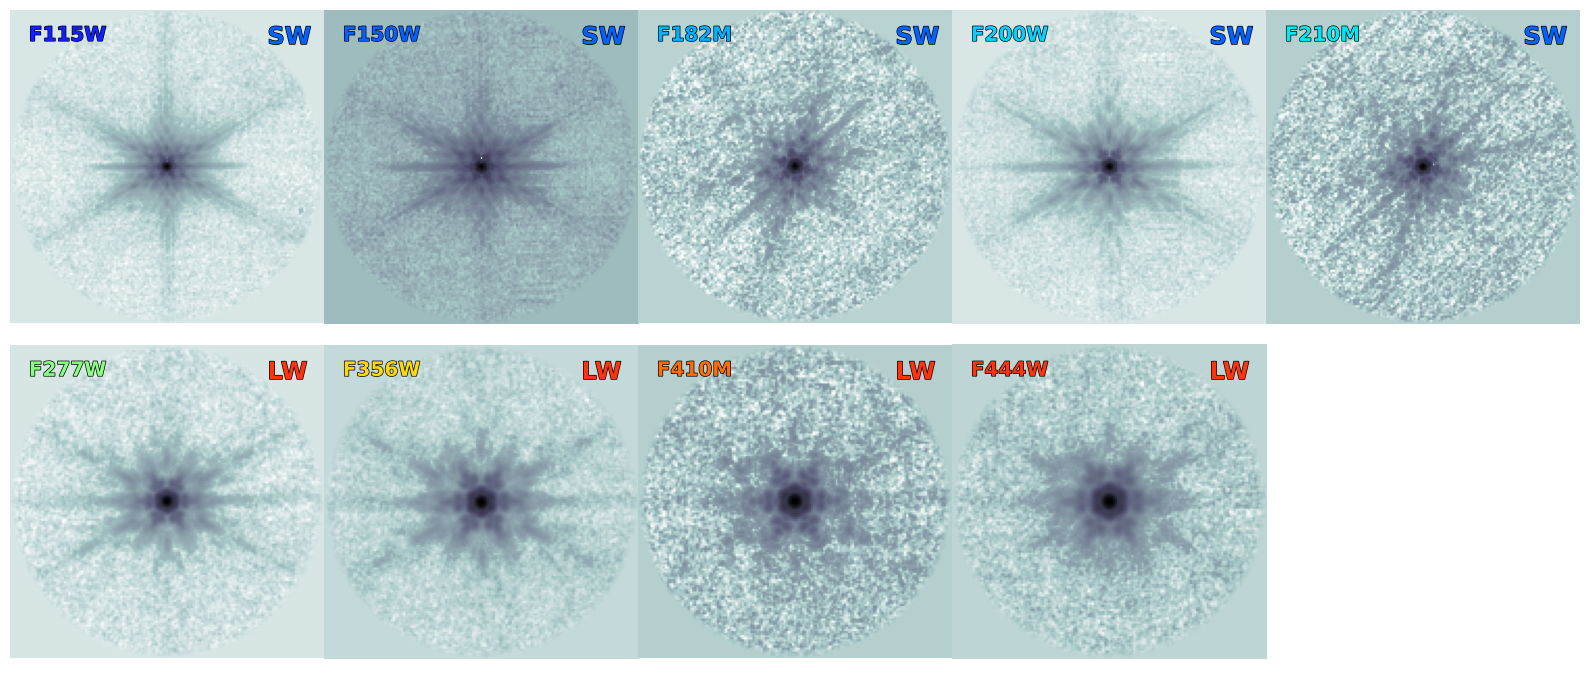

In [9]:
# Auto-sized plot to display all the PSFs
def psf_plot(ax, filter):
    with fits.open(psf_list[filter_list.index(filter)]) as image:
        psf = image[1].data[0][0][0]
    dja_sepp.psfex.psf_plot(ax, filter, psf)

fig, ax = dja_sepp.utils.plot_group_filter(filter_list, psf_plot)
fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/psfex/PSF_summary_{field}.pdf", bbox_inches='tight', pad_inches=0)
# fig.savefig(f"{home}/fields/{field}/psfex/PSF_summary_{field}.png", bbox_inches='tight', pad_inches=0, dpi=100)
plt.show()

### Save all PSFs to make GIF

It is even possible to extract all the PSFs images individually, as png, to make a GIF and see how it grows with wavelength.

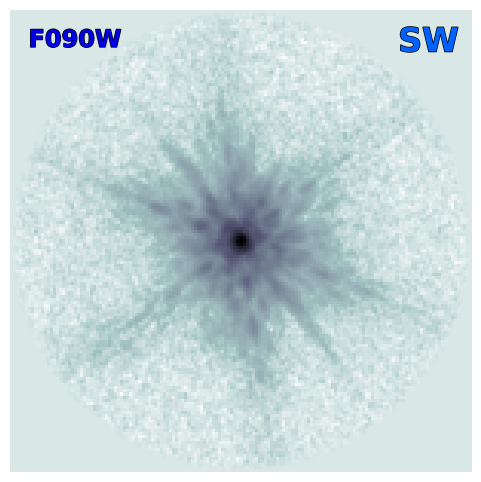

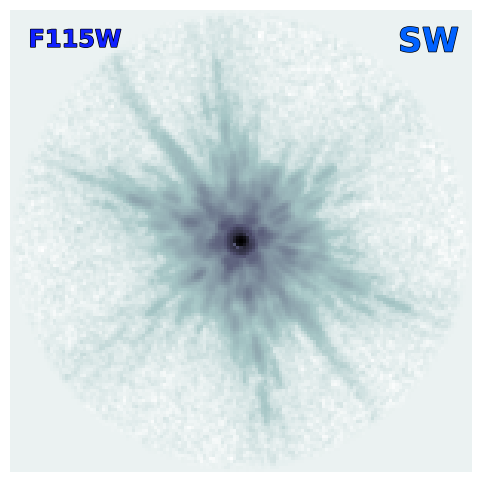

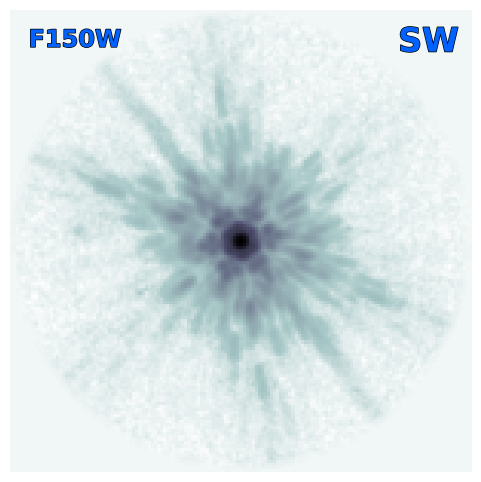

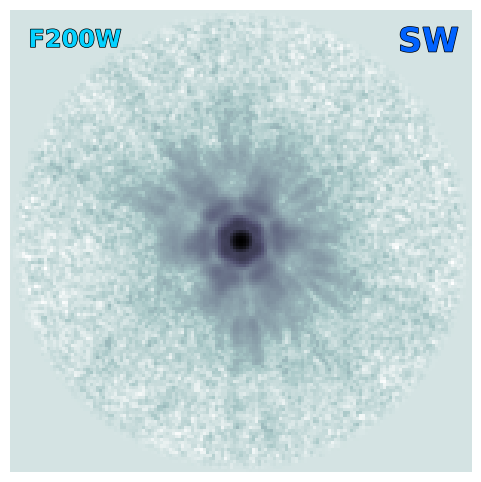

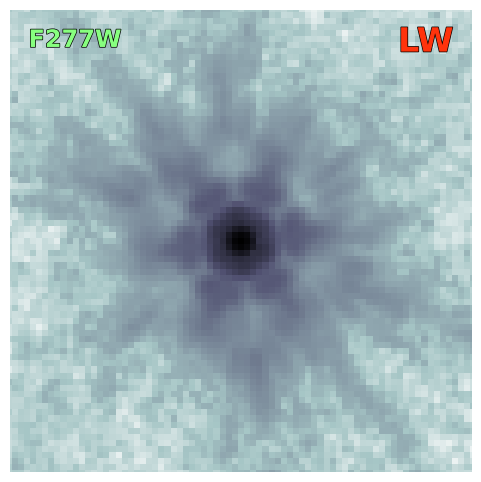

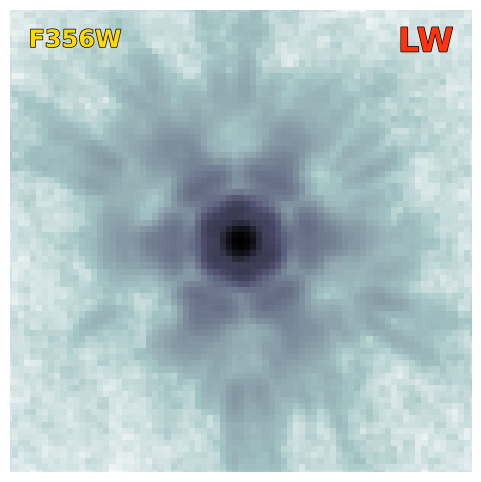

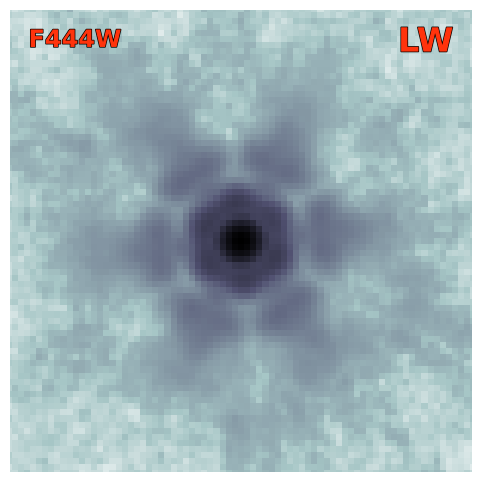

In [22]:
rescale_psf = True # To rescale images between LW and SW to account for different pixel scales
for filter in filter_list:
    image = fits.open(glob.glob(f"{home}/fields/{field}/psfex/*{filter}*star_psf.psf")[0])
    psf = image[1].data[0][0][0]
    image.close()

    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_axis_off()
    if rescale_psf:
        extent = (-100,100,-100,100) if channel_dict[filter.upper()]=='SW' else (-200,200,-200,200) # Same pixel scale
    else:
        extent = (-100,100,-100,100) # No scaling
    ax.imshow(psf, origin='lower', cmap='bone_r', norm=SymLogNorm(linthresh=1e-5, linscale=0.8), extent=extent)
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    ax.text(0.04, 0.92, filter.upper(), transform=ax.transAxes, 
            fontsize='xx-large', fontweight='bold', 
            color=color_dict[filter.upper()],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    ax.text(0.84, 0.91, channel_dict[filter.upper()], transform=ax.transAxes, 
            fontsize=24, fontweight='bold', 
            color=channel_color_dict[channel_dict[filter.upper()]],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    # if rescale_psf:
    #     fig.savefig(f"{home}/fields/{field}/psfex/scaled_{filter}.png", bbox_inches='tight', pad_inches=0, dpi=100) # Same pixel scale
    # else:
    #     fig.savefig(f"{home}/fields/{field}/psfex/{filter}.png", bbox_inches='tight', pad_inches=0, dpi=100) # No scaling
    plt.show()